## Convolutional Neural Network Implementation in PyTorch

In [1]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 

In [2]:
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "../datasets/PetImages/Cat"
    DOGS = "../datasets/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    TRAINING_DATA_PATH = "../datasets/training_data.npy"

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])


                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1

                except Exception as e:
                    pass


        np.random.shuffle(self.training_data)
        np.save("training.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)


if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [3]:
training_data = np.load("training.npy", allow_pickle=True)

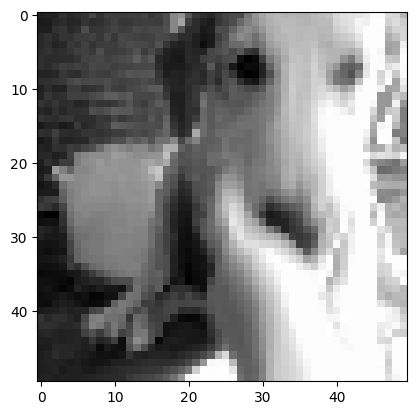

In [4]:
plt.imshow(training_data[0][0], cmap="gray")
plt.show()

In [23]:
print(f"Number of GPUs: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("USING GPU!!!!")
else:
    deivce = torch.device("cpu")
    print("USING CPU")

Number of GPUs: 1
USING GPU!!!!


In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear == None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

net = Net().to(device)

In [7]:


X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])


VAL_PCT = 0.1

val_size = int(len(X)*VAL_PCT)
print(val_size)

/tmp/ipykernel_77485/2779765271.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)


2494


In [8]:
train_X = X[:-val_size].to(device)
train_y = y[:-val_size].to(device)

test_X = X[-val_size:].to(device)
test_y = y[-val_size:].to(device)

In [18]:
import torch.optim as optim


BATCH_SIZE = 100
EPOCHS = 10

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train_1(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]
            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
    print(loss)


def test_1(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_label = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
            predicted_label = torch.argmax(net_out)

            if predicted_label == real_label:
                correct += 1
            total += 1
    print("ACCURACY:", round(correct/total, 3))
    

In [20]:
train_1(net)

100%|██████████| 225/225 [00:01<00:00, 179.07it/s]

tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)


In [21]:
test_1(net)

100%|██████████| 2494/2494 [00:03<00:00, 659.77it/s]

ACCURACY: 0.725


In [28]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()

    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

In [35]:
def test_2(size=32):
    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50), y)
    return val_acc, val_loss


val_acc, val_loss = test_2(size=32)
print(val_acc, val_loss)

0.8125 tensor(0.1510, device='cuda:0')


In [41]:
import time

MODEL_NAME = f"model-{int(time.time())}"

net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train_2():
    BATCH_SIZE = 100
    EPOCHS = 5
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE]

                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i%50 == 0:
                    val_acc, val_loss = test_2(size=32)
                    f.write(f"{MODEL_NAME}, {round(time.time(), 3)}, {round(float(acc), 2)}, {round(float(loss), 4)}, {round(float(val_acc), 2)}, {round(float(val_loss), 4)}")


train_2()


model-1721405216


  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [00:11<00:00, 20.38it/s]
